In [1]:
import json
import os
from collections import Counter
from glob import glob
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from joblib import Parallel, delayed
from scipy import integrate
from tqdm.notebook import tqdm
from vendors import Checkov

In [2]:
sns.set_style("ticks")
sns.despine(offset=10, trim=True)
sns.set_context("paper")

<Figure size 640x480 with 0 Axes>

In [3]:
def align_file_lists(list1, list2):
    basenames1 = [os.path.splitext(os.path.basename(f))[0] for f in list1]
    basenames2 = [os.path.splitext(os.path.basename(f))[0] for f in list2]

    common_basenames = set(basenames1) & set(basenames2)

    aligned1 = [f for f in list1 if os.path.splitext(os.path.basename(f))[0] in common_basenames]
    aligned2 = [f for f in list2 if os.path.splitext(os.path.basename(f))[0] in common_basenames]

    aligned1 = sorted(aligned1)
    aligned2 = sorted(aligned2)
    return aligned1, aligned2

def test_loader(testset):
    for item in testset:
        file_name = item["files"]
        ids = item["results"]
        with open(file_name, "r") as f:
            yamls = yaml.load_all(f.read(), Loader=yaml.FullLoader)
        for idx, yaml_data in enumerate(yamls):
            if idx in ids:
                yield file_name, idx, yaml_data

def extract(raw_file, q_id):
    with open(raw_file, "r") as f:
        yamls = yaml.load_all(f.read(), Loader=yaml.FullLoader)
    for idx, yaml_data in enumerate(yamls):
        if idx == q_id:
            return yaml_data

def load_test_data(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

In [4]:
# Read the CSV file with Checkov rules
checkov_rules = pd.read_csv("assets/checkov/checkov_k8s_rules.csv")
# Create a dictionary mapping id to type
id_to_type = dict(zip(checkov_rules["id"], checkov_rules["type"]))

def get_rule_type(rule_id):
    return id_to_type.get(rule_id, "Unknown")

In [5]:
testset = load_test_data("fetch_artifacthub/gathered/top_1000_split_files.json")
loader = test_loader(testset)
sat = Checkov()

def process_file(yaml_data, sat):
    raw_res = sat._scan([yaml_data])
    raw_res_ckv_ids = [item["check_id"] for item in raw_res["results"]["failed_checks"]]
    return [get_rule_type(item) for item in raw_res_ckv_ids]

In [6]:
# results = Parallel(n_jobs=-1)(delayed(process_file)(yaml_data, sat) for file_name, idx, yaml_data in tqdm(loader, total=1000))

# results = list(chain(*results))

In [7]:
def plot_bar_chart(results, title="Type Distribution", figsize=(16, 8)):

    fig, ax = plt.subplots(figsize=figsize, dpi=600)


    unique, counts = np.unique(results, return_counts=True)
    sort_idx = np.argsort(-counts)
    unique = unique[sort_idx]
    counts = counts[sort_idx]

    base_color = "#4169E1"
    n_categories = len(unique)

    colors = []
    for i in range(n_categories):
        rgb = tuple(int(base_color[1:][i : i + 2], 16) for i in (0, 2, 4))

        factor = 0.7 + (i * 0.3 / n_categories)
        adjusted_rgb = tuple(min(int(c * factor), 255) for c in rgb)

        color = "#{:02x}{:02x}{:02x}".format(*adjusted_rgb)
        colors.append(color)

    bars = ax.bar(range(len(unique)), counts, color=colors, width=1, alpha=0.85, edgecolor="white", linewidth=1)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{int(height)}", ha="center", va="bottom", fontsize=12, fontweight="normal", color="#444444")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)

    ax.yaxis.grid(True, linestyle="--", alpha=0.2, color="gray")

    ax.set_xticks(range(len(unique)))
    ax.set_xticklabels(unique, rotation=90, ha="right")
    ax.set_xlim(-0.5, len(unique) - 0.5)

    ax.tick_params(axis='x', length=0)

    ax.tick_params(axis="both", which="major", labelsize=12, pad=5)
    # ax.set_xlabel("Categories", fontsize=13, labelpad=10)
    ax.set_ylabel("Count", fontsize=13, labelpad=10)

    # ax.set_title(title, fontsize=15, pad=15, fontweight="bold", loc="left")

    ax.set_ylim(0, max(counts) * 1.15)

    plt.tight_layout()
    plt.savefig('data_distro.svg', format='svg')
    return fig

In [8]:
# bar = plot_bar_chart(results)

In [9]:
csv_files = glob("./test/checkov/*.csv")

In [10]:
def count_true_false_na(df):
    tf = df["passes"].value_counts()
    try:
        t = tf[True]
    except:
        t = 0
    try:
        f = tf[False]
    except:
        f = 0
    na = df["passes"].isna().sum()
    return t, f, na

def get_result(csv_file, name="model", max_steps=10):
    df = pd.read_csv(csv_file)
    if name == "model":
        model_name = csv_file.split("_")[-1].split(".")[0]
    elif name == "type":
        model_name = csv_file.split("/")[0].split("_")[-1]

    t, f, na = count_true_false_na(df)

    parse_suc_rate = (len(df) - na) / len(df)
    pass_rate = t / len(df)
    avg_pass_step = (df["step_id"][df["passes"] == True] + 1).sum() / t

    result = {"LLM": model_name, "Parse Rate": round(parse_suc_rate, 4), "Pass Rate": round(pass_rate, 4), "Avg. Pass Steps": round(avg_pass_step, 2)}

    #######################
    max_steps = max(int(df["step_id"].max()) + 1, max_steps)
    pass_rates = []
    avg_pass_steps = []
    for i_step in range(max_steps):
        # Create a copy of the DataFrame
        tmp_df = df.copy()

        # Vectorized operation to update passes
        mask = (tmp_df["passes"] == True) & (tmp_df["step_id"] > i_step)
        tmp_df.loc[mask, "passes"] = False

        # Assuming count_true_false_na is a function you have defined
        t, f, na = count_true_false_na(tmp_df)
        pass_rates.append(round(t / len(df), 4))
        avg_pass_steps.append(round((tmp_df["step_id"][tmp_df["passes"] == True] + 1).sum() / t, 4))
    return result, pass_rates, avg_pass_steps
    # df["passes"].count()

In [11]:
csv_files = csv_files[1:-1]
csv_files

['./test/checkov/checkov_gpt-4o-mini.csv',
 './test/checkov/checkov_mistral-large-2407.csv']

In [12]:
y_lists = []
model_names = []
avg_steps = []
result_lists = []
for csv_file in csv_files:
    result, pass_rates, avg_pass_steps = get_result(csv_file)
    result_lists.append(result)
    y_lists.append(pass_rates)
    avg_steps.append(avg_pass_steps)
    model_names.append(result["LLM"])

In [13]:
def plot_rates_over_steps(y_lists, model_names, title="Pass Rate over Steps", y_label="Pass Rate", figsize=(8, 6), save_name="prs"):
    fig, ax = plt.subplots(figsize=figsize, dpi=600)

    x = np.arange(1, len(y_lists[0]) + 1)

    colors = ["#4e79a7", "#f28e2b", "#59a14f", "#e15759", "#76b7b2", "#edc948"]
    markers = ["o", "s", "^", "D", "v", "<"]

    aucs = []
    for idx, (y_data, name) in enumerate(zip(y_lists, model_names)):
        # 计算AUC
        auc = np.trapz(y_data, x) / len(x)
        aucs.append(auc)

        # 绘制线条和标记
        line = ax.plot(
            x, y_data, color=colors[idx % len(colors)], marker=markers[idx % len(markers)], linewidth=2, markersize=6, label=f"{name} (AUC: {auc:.3f})", markerfacecolor="white", markeredgewidth=1.5
        )

        # 填充曲线下方区域
        ax.fill_between(x, y_data, color=colors[idx % len(colors)], alpha=0.3)

    # 设置轴样式
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)

    # 添加网格线
    ax.grid(True, linestyle="--", alpha=0.2, color="gray", linewidth=0.5)

    # 设置刻度
    ax.tick_params(direction="out", length=4, width=0.8, labelsize=10)

    # 设置标签
    ax.set_xlabel("Steps", fontsize=11, labelpad=8)
    ax.set_ylabel(y_label, fontsize=11, labelpad=8)
    # ax.set_title(title, fontsize=12, pad=10, fontweight="bold", loc="left")

    # 设置图例
    legend = ax.legend(loc="lower right", fontsize=12, frameon=True, edgecolor="none", facecolor="white", framealpha=0.8, bbox_to_anchor=(1, 0.02))

    # 设置轴范围
    ax.set_xlim(1, len(x))  # 调整以确保从1开始

    # 设置x轴刻度为整数
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))

    # 计算y轴范围
    if title.lower().startswith("avg"):
        y_min, y_max = np.min([np.min(y) for y in y_lists]), np.max([np.max(y) for y in y_lists])
        y_margin = (y_max - y_min) * 0.1
        ax.set_ylim(1, y_max + y_margin)
    else:
        y_min, y_max = np.min([np.min(y) for y in y_lists]), np.max([np.max(y) for y in y_lists])
        y_margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

    plt.tight_layout()
    plt.savefig(f'{save_name}.svg', format='svg')
    return fig, aucs

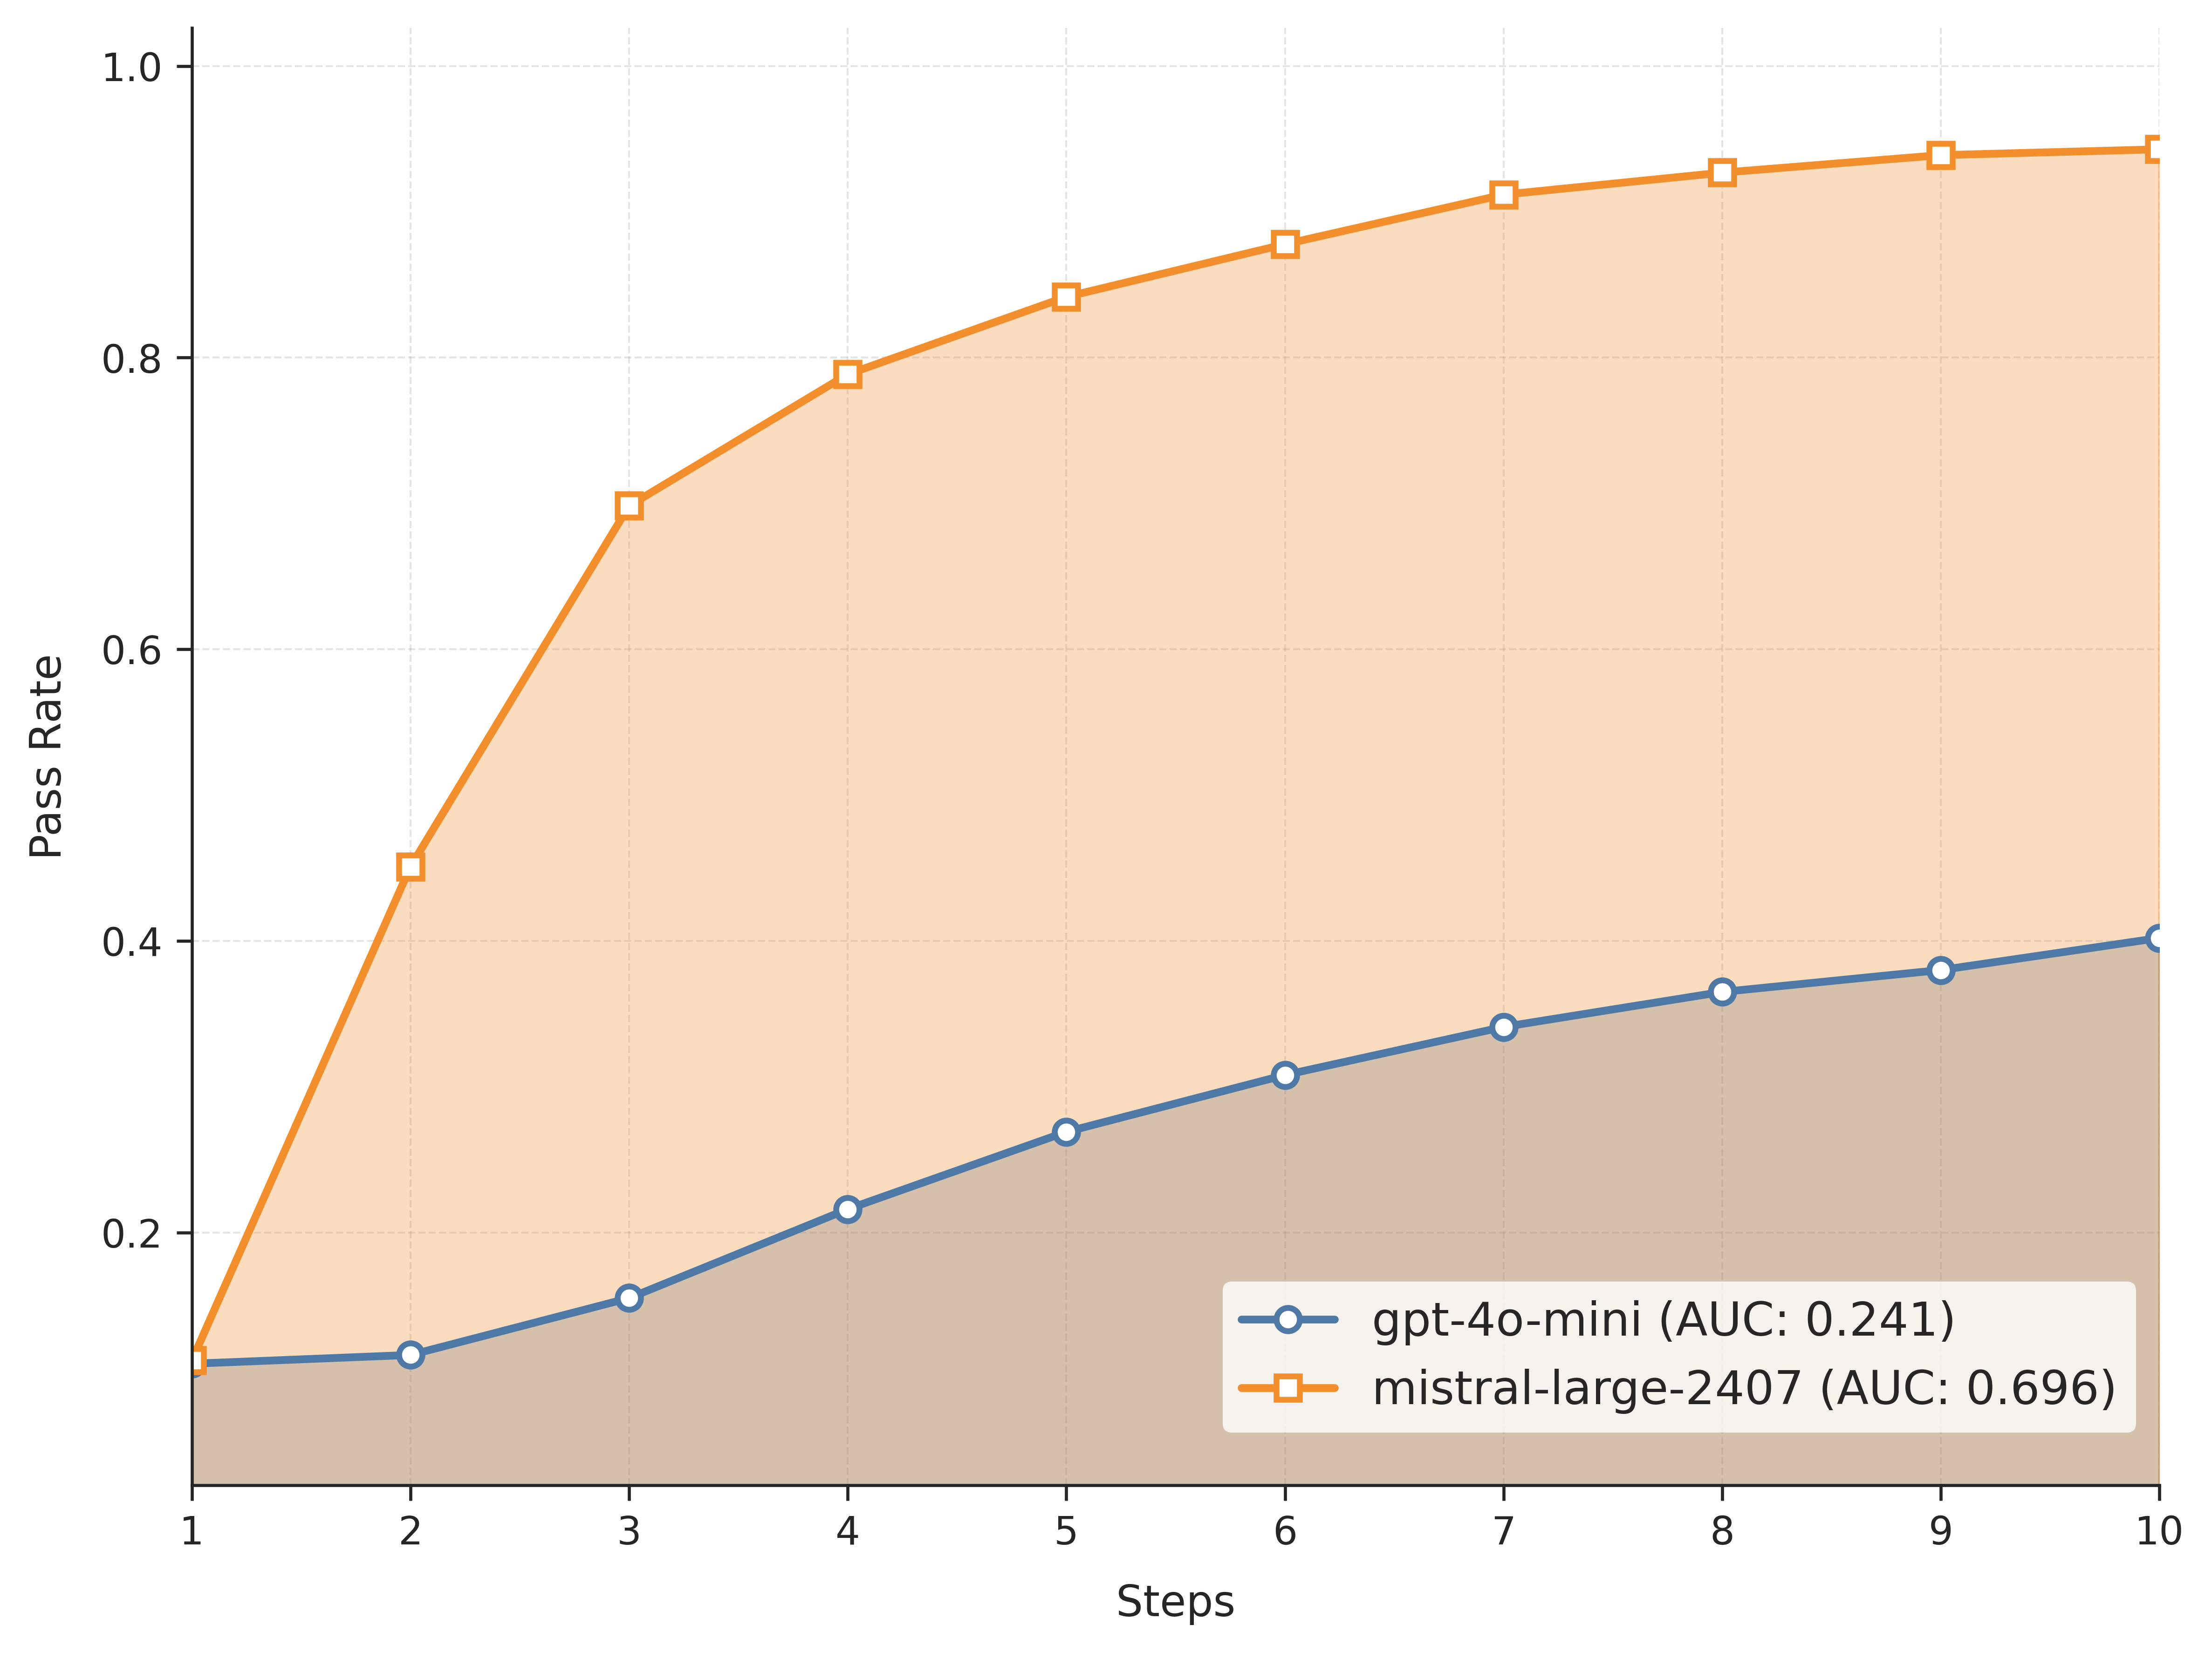

In [14]:
fig1, aucs = plot_rates_over_steps(y_lists, model_names, save_name="prs")
for result, auc in zip(result_lists, aucs):
    result.update({"PRS_AUC": round(auc, 4)})

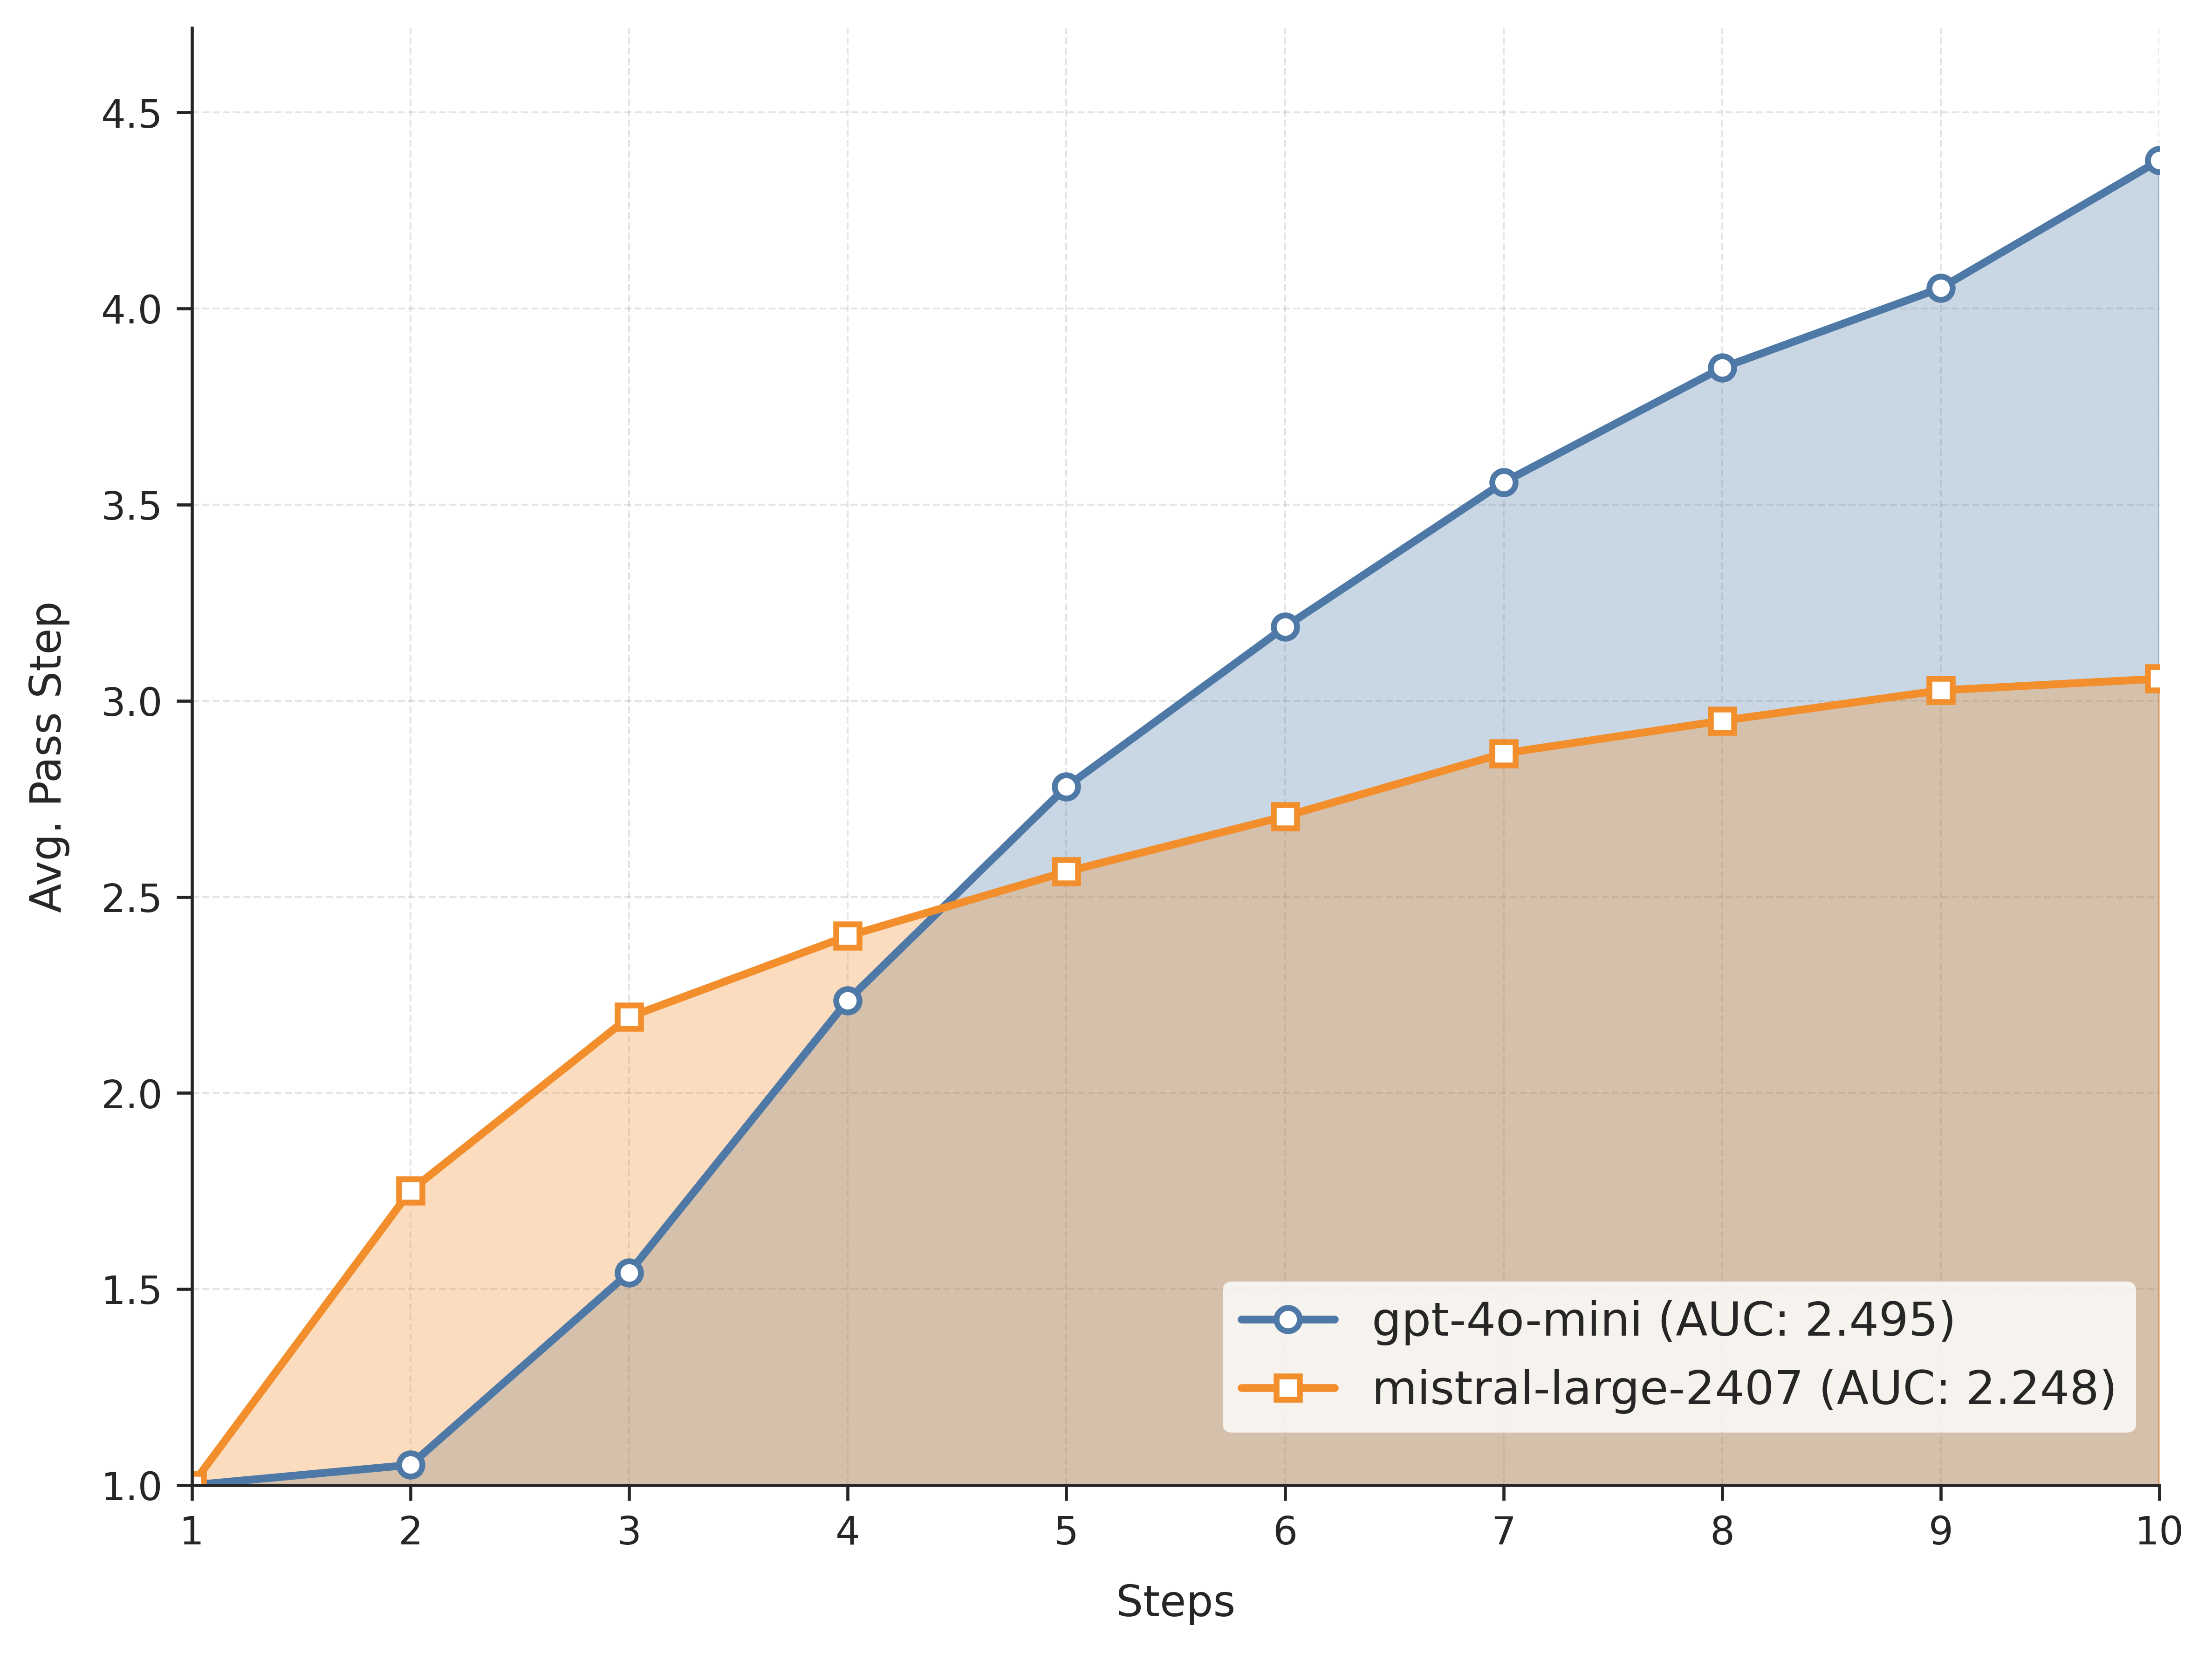

In [15]:
fig2, aucs = plot_rates_over_steps(avg_steps, model_names, title="Avg. Pass Steps over Steps", y_label="Avg. Pass Step", save_name="apss")
for result, auc in zip(result_lists, aucs):
    result.update({"APSS_AUC": round(auc, 4)})

In [16]:
# Data preparation
def prepare_data(df):
    df["fixed_types"] = df["fixed"].apply(lambda x: [get_rule_type(rule) for rule in x])
    df["introduced_types"] = df["introduced"].apply(lambda x: [get_rule_type(rule) for rule in x])
    df["hard_to_fix_types"] = df["hard_to_fix"].apply(lambda x: [get_rule_type(rule) for rule in x])
    df["effectiveness"] = (df["num_fixed"] - df["num_introduced"]) / df["raw_err_num"]
    df["effectiveness"] = df["effectiveness"].fillna(0)
    return df

In [17]:
def process_file_detailed(json_file, yaml_file, raw_yaml, idx, sat):
    raw_yaml = extract(raw_yaml, idx)
    with open(json_file, "r") as f:
        fixed_res = json.loads(f.read())
    
    try:
        if fixed_res["results"]["failed_checks"] != []:
            fixed_res_ckv_ids = [item["check_id"] for item in fixed_res["results"]["failed_checks"]]
        else:
            fixed_res_ckv_ids = []
    except:
        return None

    raw_res = sat._scan([raw_yaml])
    raw_res_ckv_ids = [item["check_id"] for item in raw_res["results"]["failed_checks"]]

    hard_to_fix = set(fixed_res_ckv_ids) & set(raw_res_ckv_ids)

    introduced = set(fixed_res_ckv_ids) - set(raw_res_ckv_ids)
    num_introduced = len(introduced)
    raw_err_num = raw_res["summary"]["failed"]
    fixed_err_num = fixed_res["summary"]["failed"]
    fixed = set(raw_res_ckv_ids) - set(fixed_res_ckv_ids)
    num_fixed = len(fixed)

    return {
        "json_file": json_file,
        "idx": idx,
        "yaml_file": yaml_file,
        "raw_res_ckv_ids": raw_res_ckv_ids,
        "raw_err_num": raw_err_num,
        "fixed_res_ckv_ids": fixed_res_ckv_ids,
        "fixed_err_num": fixed_err_num,
        "fixed": fixed,
        "num_fixed": num_fixed,
        "introduced": introduced,
        "num_introduced": num_introduced,
        "hard_to_fix": hard_to_fix,
    }

In [18]:
def success_rate_by_type(fixed_types, raw_types):
    """Calculate success rates for each rule type."""
    all_fixed = [item for sublist in fixed_types for item in sublist]
    all_raw = [item for sublist in raw_types for item in sublist]

    fixed_counts = Counter(all_fixed)
    raw_counts = Counter(all_raw)

    success_rates = {}
    for rule_type in set(all_raw):
        fixed = fixed_counts.get(rule_type, 0)
        raw = raw_counts.get(rule_type, 0)
        success_rates[rule_type] = fixed / raw if raw > 0 else 0

    return success_rates

def plot_success_rates(success_rates, title="Pass Rate by Rule Type", suffix="gpt-4o-mini", figsize=(16, 8), prefix=""):
    fig, ax = plt.subplots(figsize=figsize, dpi=600)

    filtered_rates = {k: v for k, v in success_rates.items() if v <= 1.0}
    if not filtered_rates:
        filtered_rates = success_rates

    sorted_items = sorted(filtered_rates.items(), key=lambda x: x[1])
    rule_types, rates = zip(*sorted_items)

    base_color = "#4169E1"
    n_categories = len(rule_types)
    colors = []
    for i in range(n_categories):
        rgb = tuple(int(base_color[1:][i : i + 2], 16) for i in (0, 2, 4))
        factor = 0.7 + (i * 0.3 / n_categories)
        adjusted_rgb = tuple(min(int(c * factor), 255) for c in rgb)
        color = "#{:02x}{:02x}{:02x}".format(*adjusted_rgb)
        colors.append(color)

    bars = ax.bar(range(len(rule_types)), rates, color=colors, width=1, alpha=0.85, edgecolor="white", linewidth=1)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.2f}", ha="center", va="bottom", fontsize=12, fontweight="normal", color="#444444")

    ax.axhline(y=0.5, color="#E15759", linestyle="--", linewidth=1.5, label="50% Pass Rate", alpha=0.8)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)

    ax.yaxis.grid(True, linestyle="--", alpha=0.2, color="gray")

    ax.set_xticks(range(len(rule_types)))
    # ax.set_xticklabels(rule_types, rotation=330, ha="left")
    ax.set_xticklabels(rule_types, rotation=90, ha="right")

    ax.set_xlim(-0.5, len(rule_types) - 0.5)

    ax.tick_params(axis="both", which="major", labelsize=12, pad=5)
    # ax.set_xlabel("Rule Type", fontsize=13, labelpad=10)
    ax.set_ylabel("Pass Rate", fontsize=13, labelpad=10)

    # ax.set_title(f"{title} ({suffix})", fontsize=15, pad=15, fontweight="bold", loc="left")

    ax.set_ylim(0, max(rates) * 1.15)

    legend = ax.legend(fontsize=12, frameon=True, edgecolor="none", facecolor="white", framealpha=0.8, loc="lower right")

    plt.tight_layout()
    if prefix == "":
        filename= f"{suffix}_result.svg"
    else:
        filename = f"{prefix}_{suffix}_result.svg"
    plt.savefig(filename, format="svg")
    plt.show()

    return fig

In [19]:
# overalls = []
# avg_num_intros = []
# for csv_file in csv_files:
#     model_name = csv_file.split("_")[-1].split(".")[0]
#     json_files = glob(f"test/checkov/*---{model_name}_*.json")
#     yaml_files = glob(f"test/checkov/*---{model_name}_*.yaml")
#     json_files, yaml_files = align_file_lists(json_files, yaml_files)
#     ids = [int(Path(item).stem.split("_")[-1]) for item in yaml_files]
#     repo_app_name = [Path(item).stem.split("---")[0] for item in yaml_files]
#     raw_yaml = [f"fetch_artifacthub/assets/{item}.yaml" for item in repo_app_name]

#     tmp_results = Parallel(n_jobs=-1)(
#         delayed(process_file_detailed)(json_file, yaml_file, raw_yaml, idx, sat) for json_file, yaml_file, raw_yaml, idx in tqdm(zip(json_files, yaml_files, raw_yaml, ids), total=len(json_files))
#     )
#     results = []
#     for result in tmp_results:
#         if result:
#             results.append(result)

#     df = pd.DataFrame(results)
#     df = prepare_data(df)

#     success_rates = success_rate_by_type(df["fixed_types"], df["raw_res_ckv_ids"].apply(lambda x: [get_rule_type(rule) for rule in x]))
#     plot_success_rates(success_rates, suffix=model_name)

#     total_raw_errors = df["raw_err_num"].sum()
#     total_fixed_errors = df["fixed_err_num"].sum()
#     overall_improvement = (total_raw_errors - total_fixed_errors) / total_raw_errors
#     overalls.append(overall_improvement)
#     avg_num_intros.append(df["num_introduced"].mean())

In [20]:
# for result, overall in zip(result_lists, overalls):
#     result.update({"Sec Imp": round(overall, 4)})
# for result, avg_num_intro in zip(result_lists, avg_num_intros):
#     result.update({"Avg. Introduced Err": round(avg_num_intro, 4)})

In [21]:
result_df = pd.DataFrame(result_lists)
result_df.to_csv("result.csv")

In [22]:
abl_csv_files = glob("test_*/checkov/*.csv")

In [23]:
y_lists = []
model_names = []
avg_steps = []
result_lists = []
for abl_csv_file in abl_csv_files:
    result, pass_rates, avg_pass_steps = get_result(abl_csv_file, "type")
    result_lists.append(result)
    y_lists.append(pass_rates)
    avg_steps.append(avg_pass_steps)
    model_names.append(result["LLM"])

  0%|          | 0/979 [00:00<?, ?it/s]

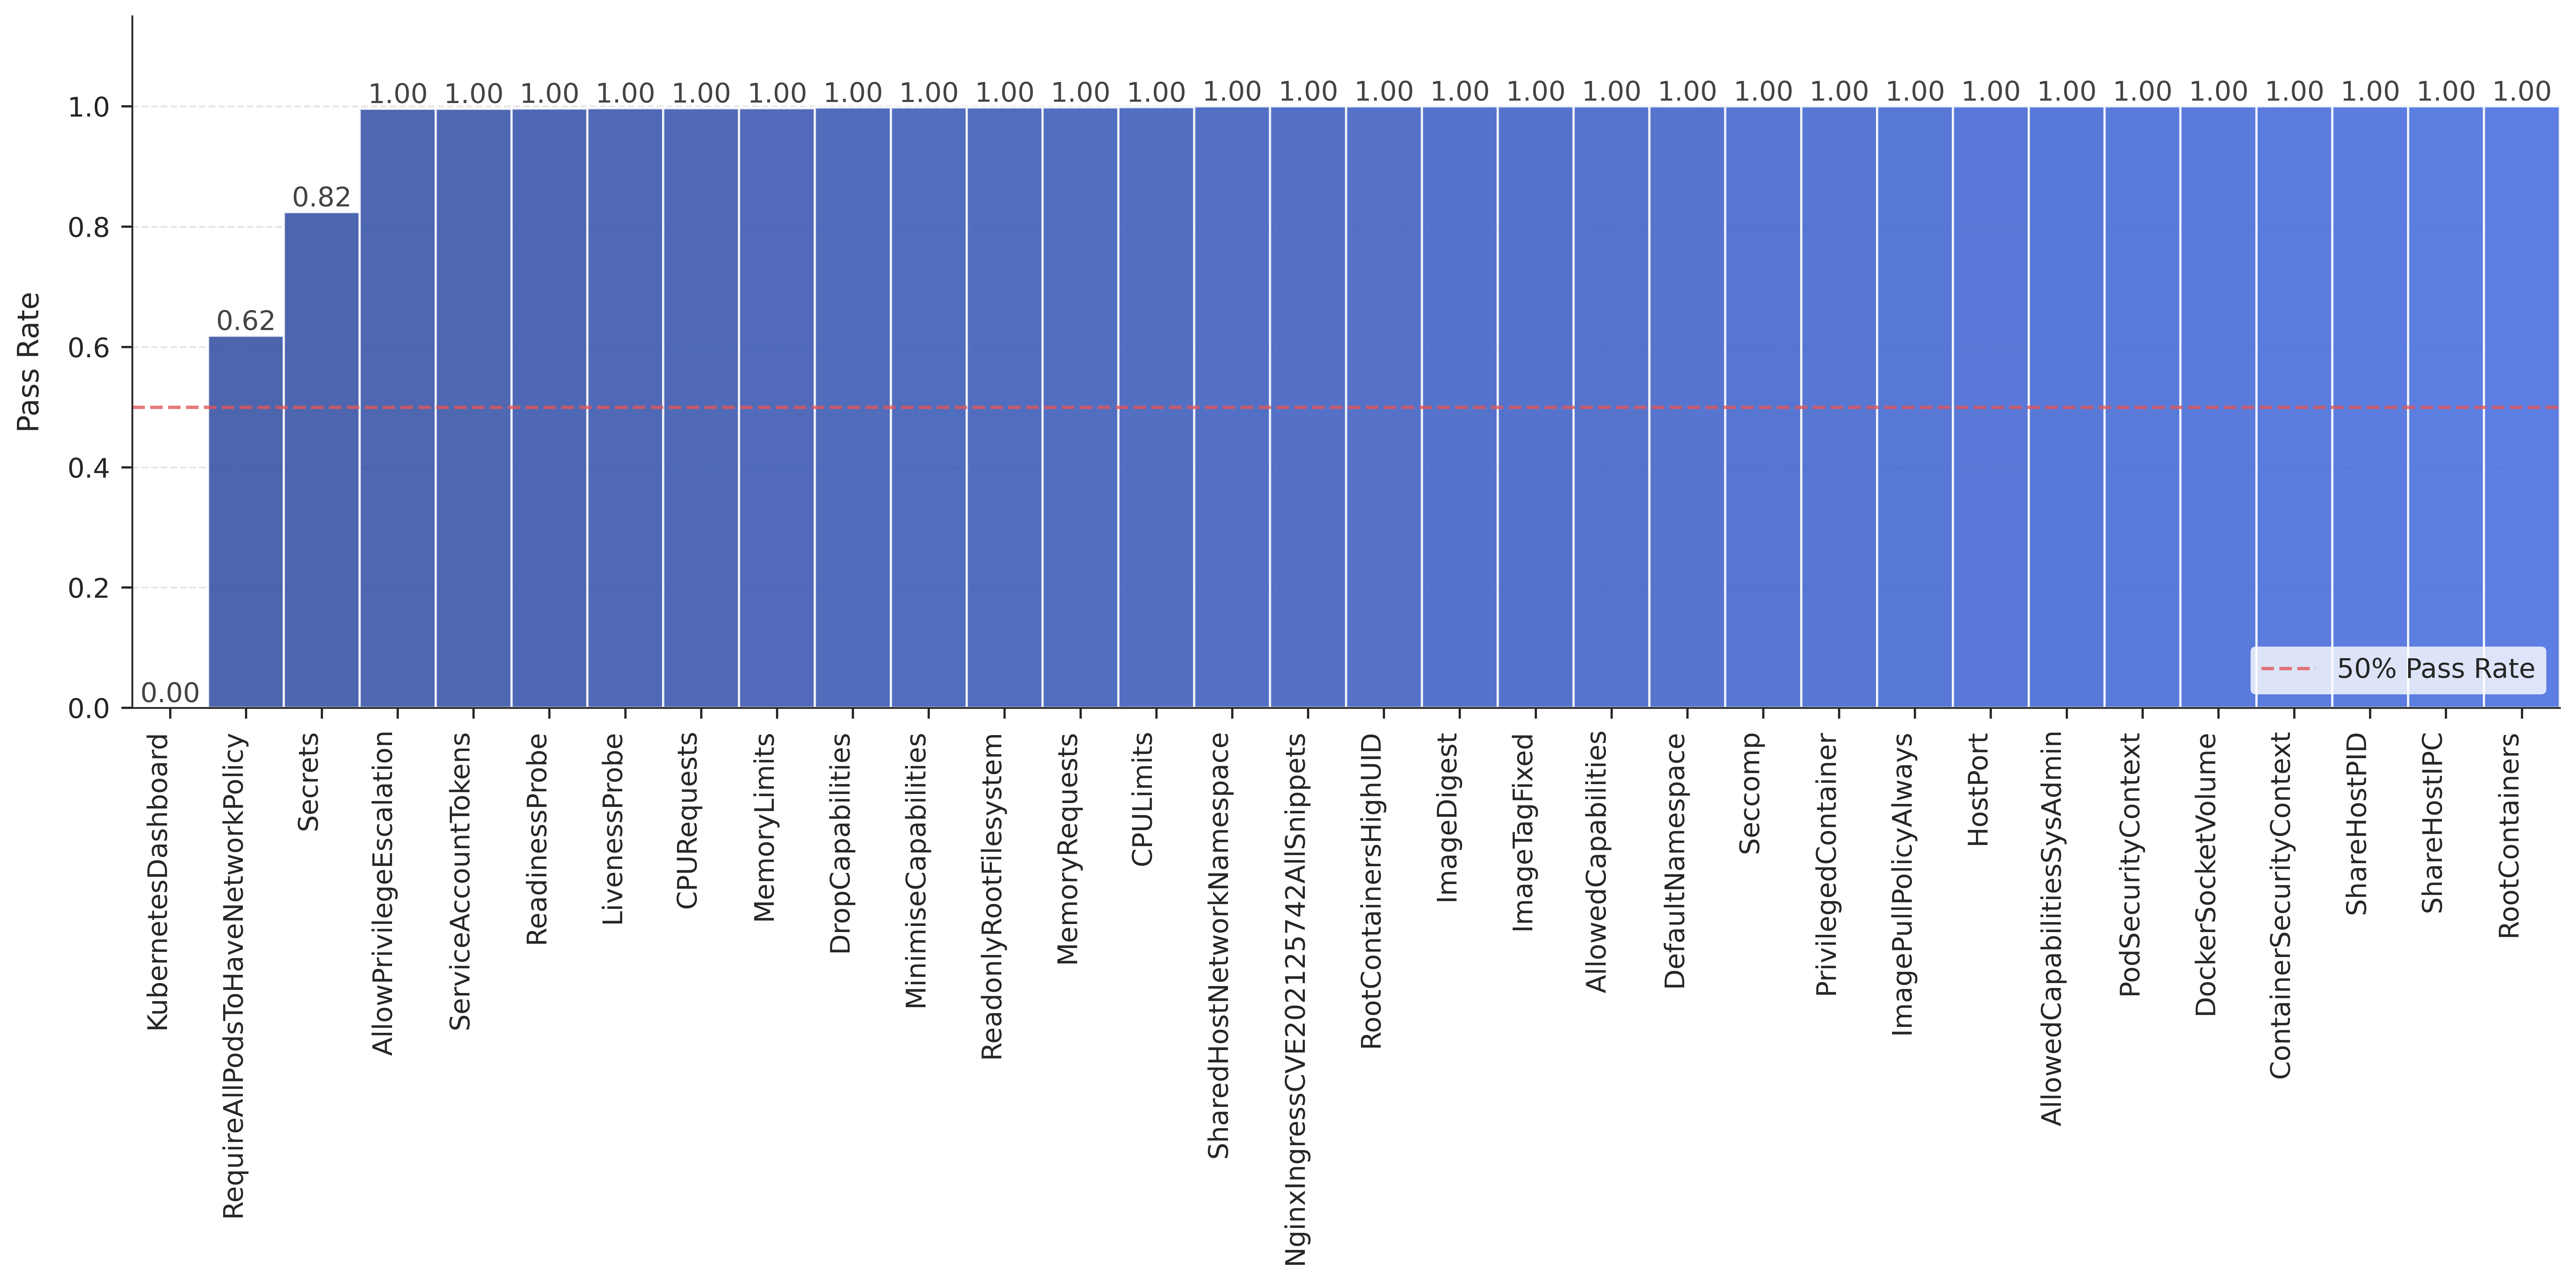

  0%|          | 0/929 [00:00<?, ?it/s]

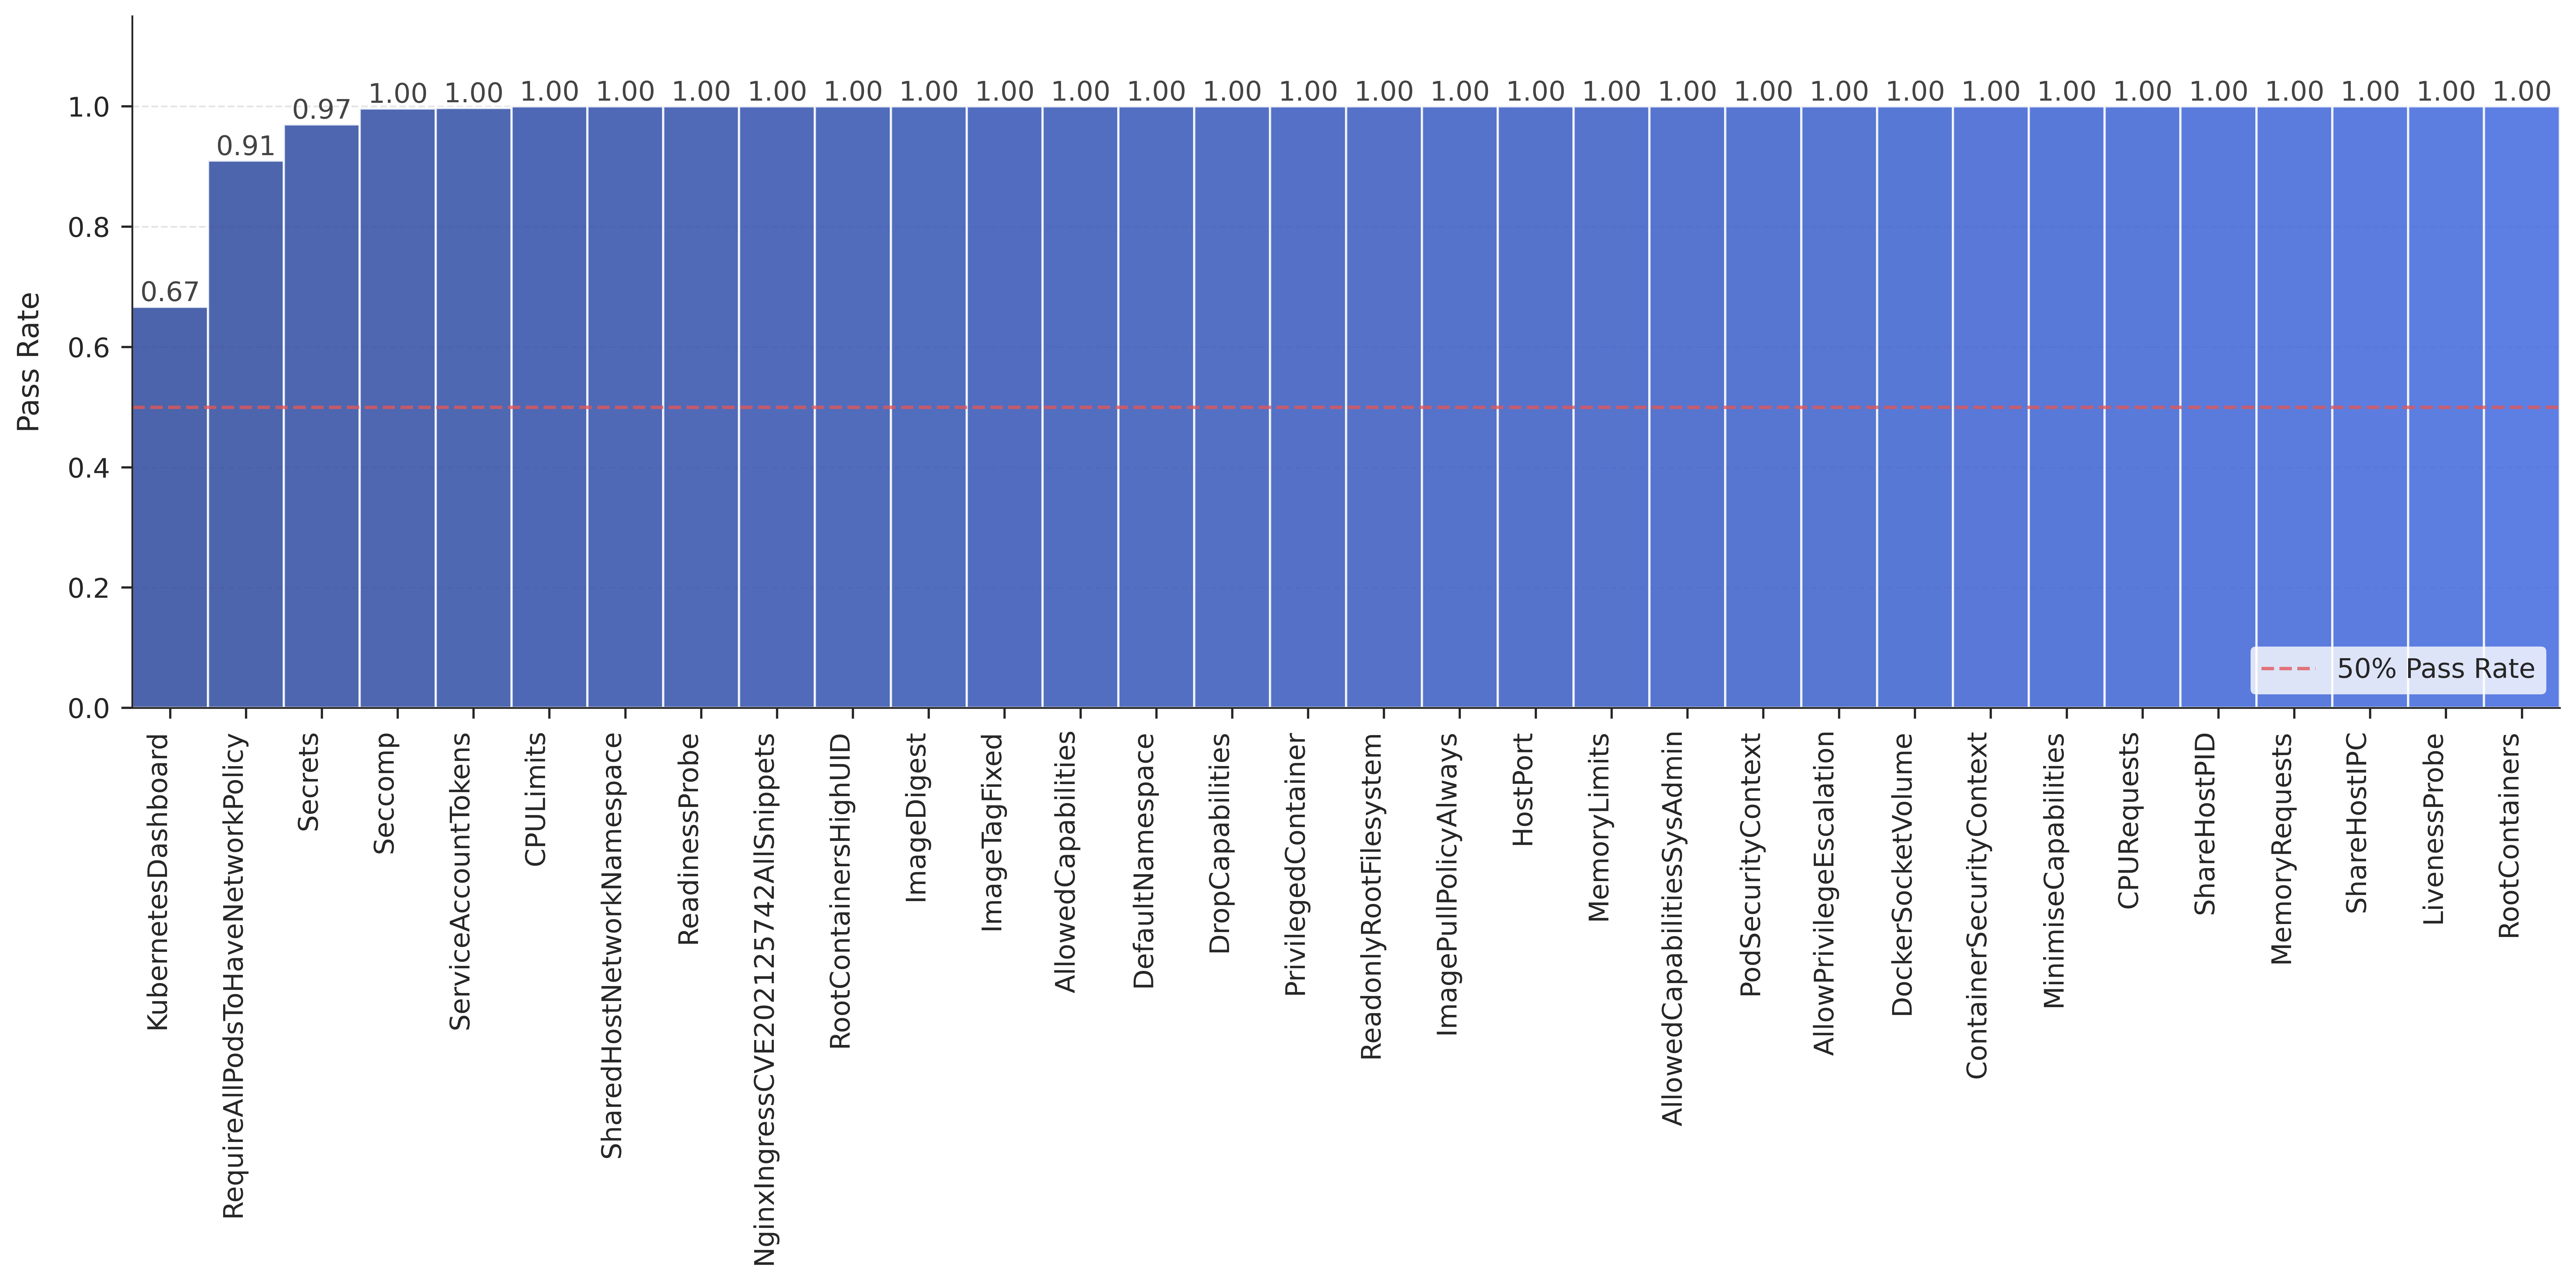

  0%|          | 0/959 [00:00<?, ?it/s]

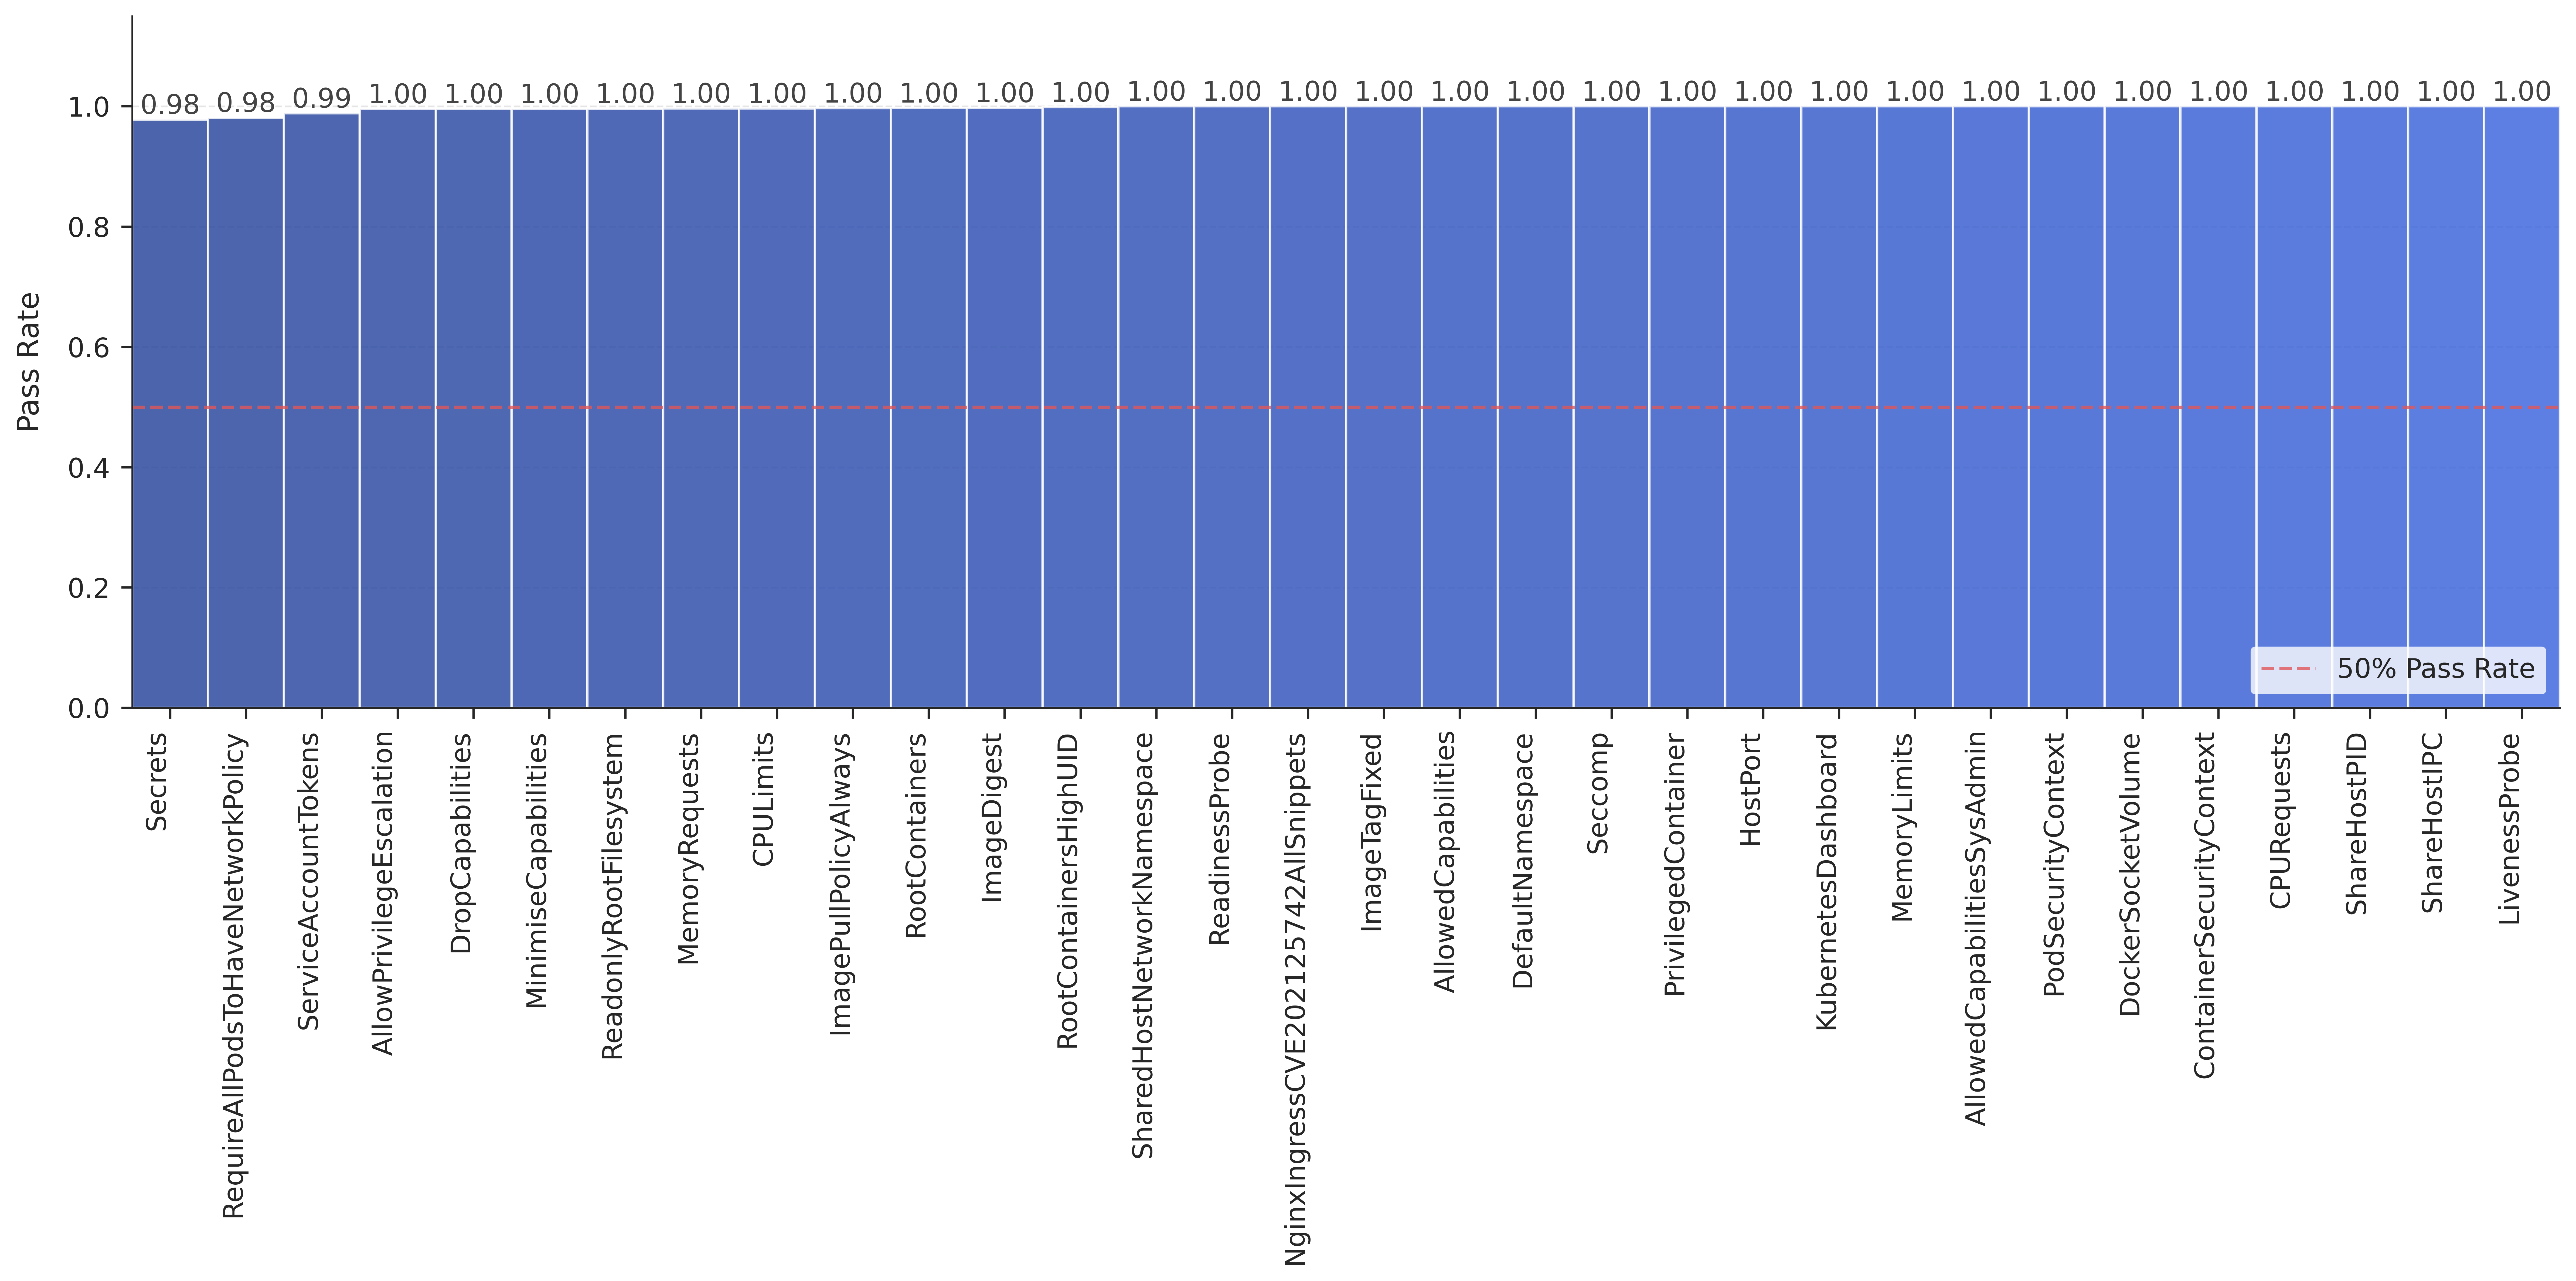

In [24]:
overalls = []
avg_num_intros = []
for abl_csv_file in abl_csv_files:
    prefix = abl_csv_file.split("/")[0].split("_")[-1]
    model_name = abl_csv_file.split("_")[-1].split(".")[0]
    json_files = glob(f"test_{prefix}/checkov/*---{model_name}_*.json")
    yaml_files = glob(f"test_{prefix}/checkov/*---{model_name}_*.yaml")
    json_files, yaml_files = align_file_lists(json_files, yaml_files)
    ids = [int(Path(item).stem.split("_")[-1]) for item in yaml_files]
    repo_app_name = [Path(item).stem.split("---")[0] for item in yaml_files]
    raw_yaml = [f"fetch_artifacthub/assets/{item}.yaml" for item in repo_app_name]

    tmp_results = Parallel(n_jobs=-1)(
        delayed(process_file_detailed)(json_file, yaml_file, raw_yaml, idx, sat) for json_file, yaml_file, raw_yaml, idx in tqdm(zip(json_files, yaml_files, raw_yaml, ids), total=len(json_files))
    )
    results = []
    for result in tmp_results:
        if result:
            results.append(result)

    df = pd.DataFrame(results)
    df = prepare_data(df)

    success_rates = success_rate_by_type(df["fixed_types"], df["raw_res_ckv_ids"].apply(lambda x: [get_rule_type(rule) for rule in x]))
    plot_success_rates(success_rates, suffix=prefix, prefix="abl")

    total_raw_errors = df["raw_err_num"].sum()
    total_fixed_errors = df["fixed_err_num"].sum()
    overall_improvement = (total_raw_errors - total_fixed_errors) / total_raw_errors
    overalls.append(overall_improvement)
    avg_num_intros.append(df["num_introduced"].mean())

In [25]:
for result, overall in zip(result_lists, overalls):
    result.update({"Sec Imp": round(overall, 4)})
for result, avg_num_intro in zip(result_lists, avg_num_intros):
    result.update({"Avg. Introduced Err": round(avg_num_intro, 4)})

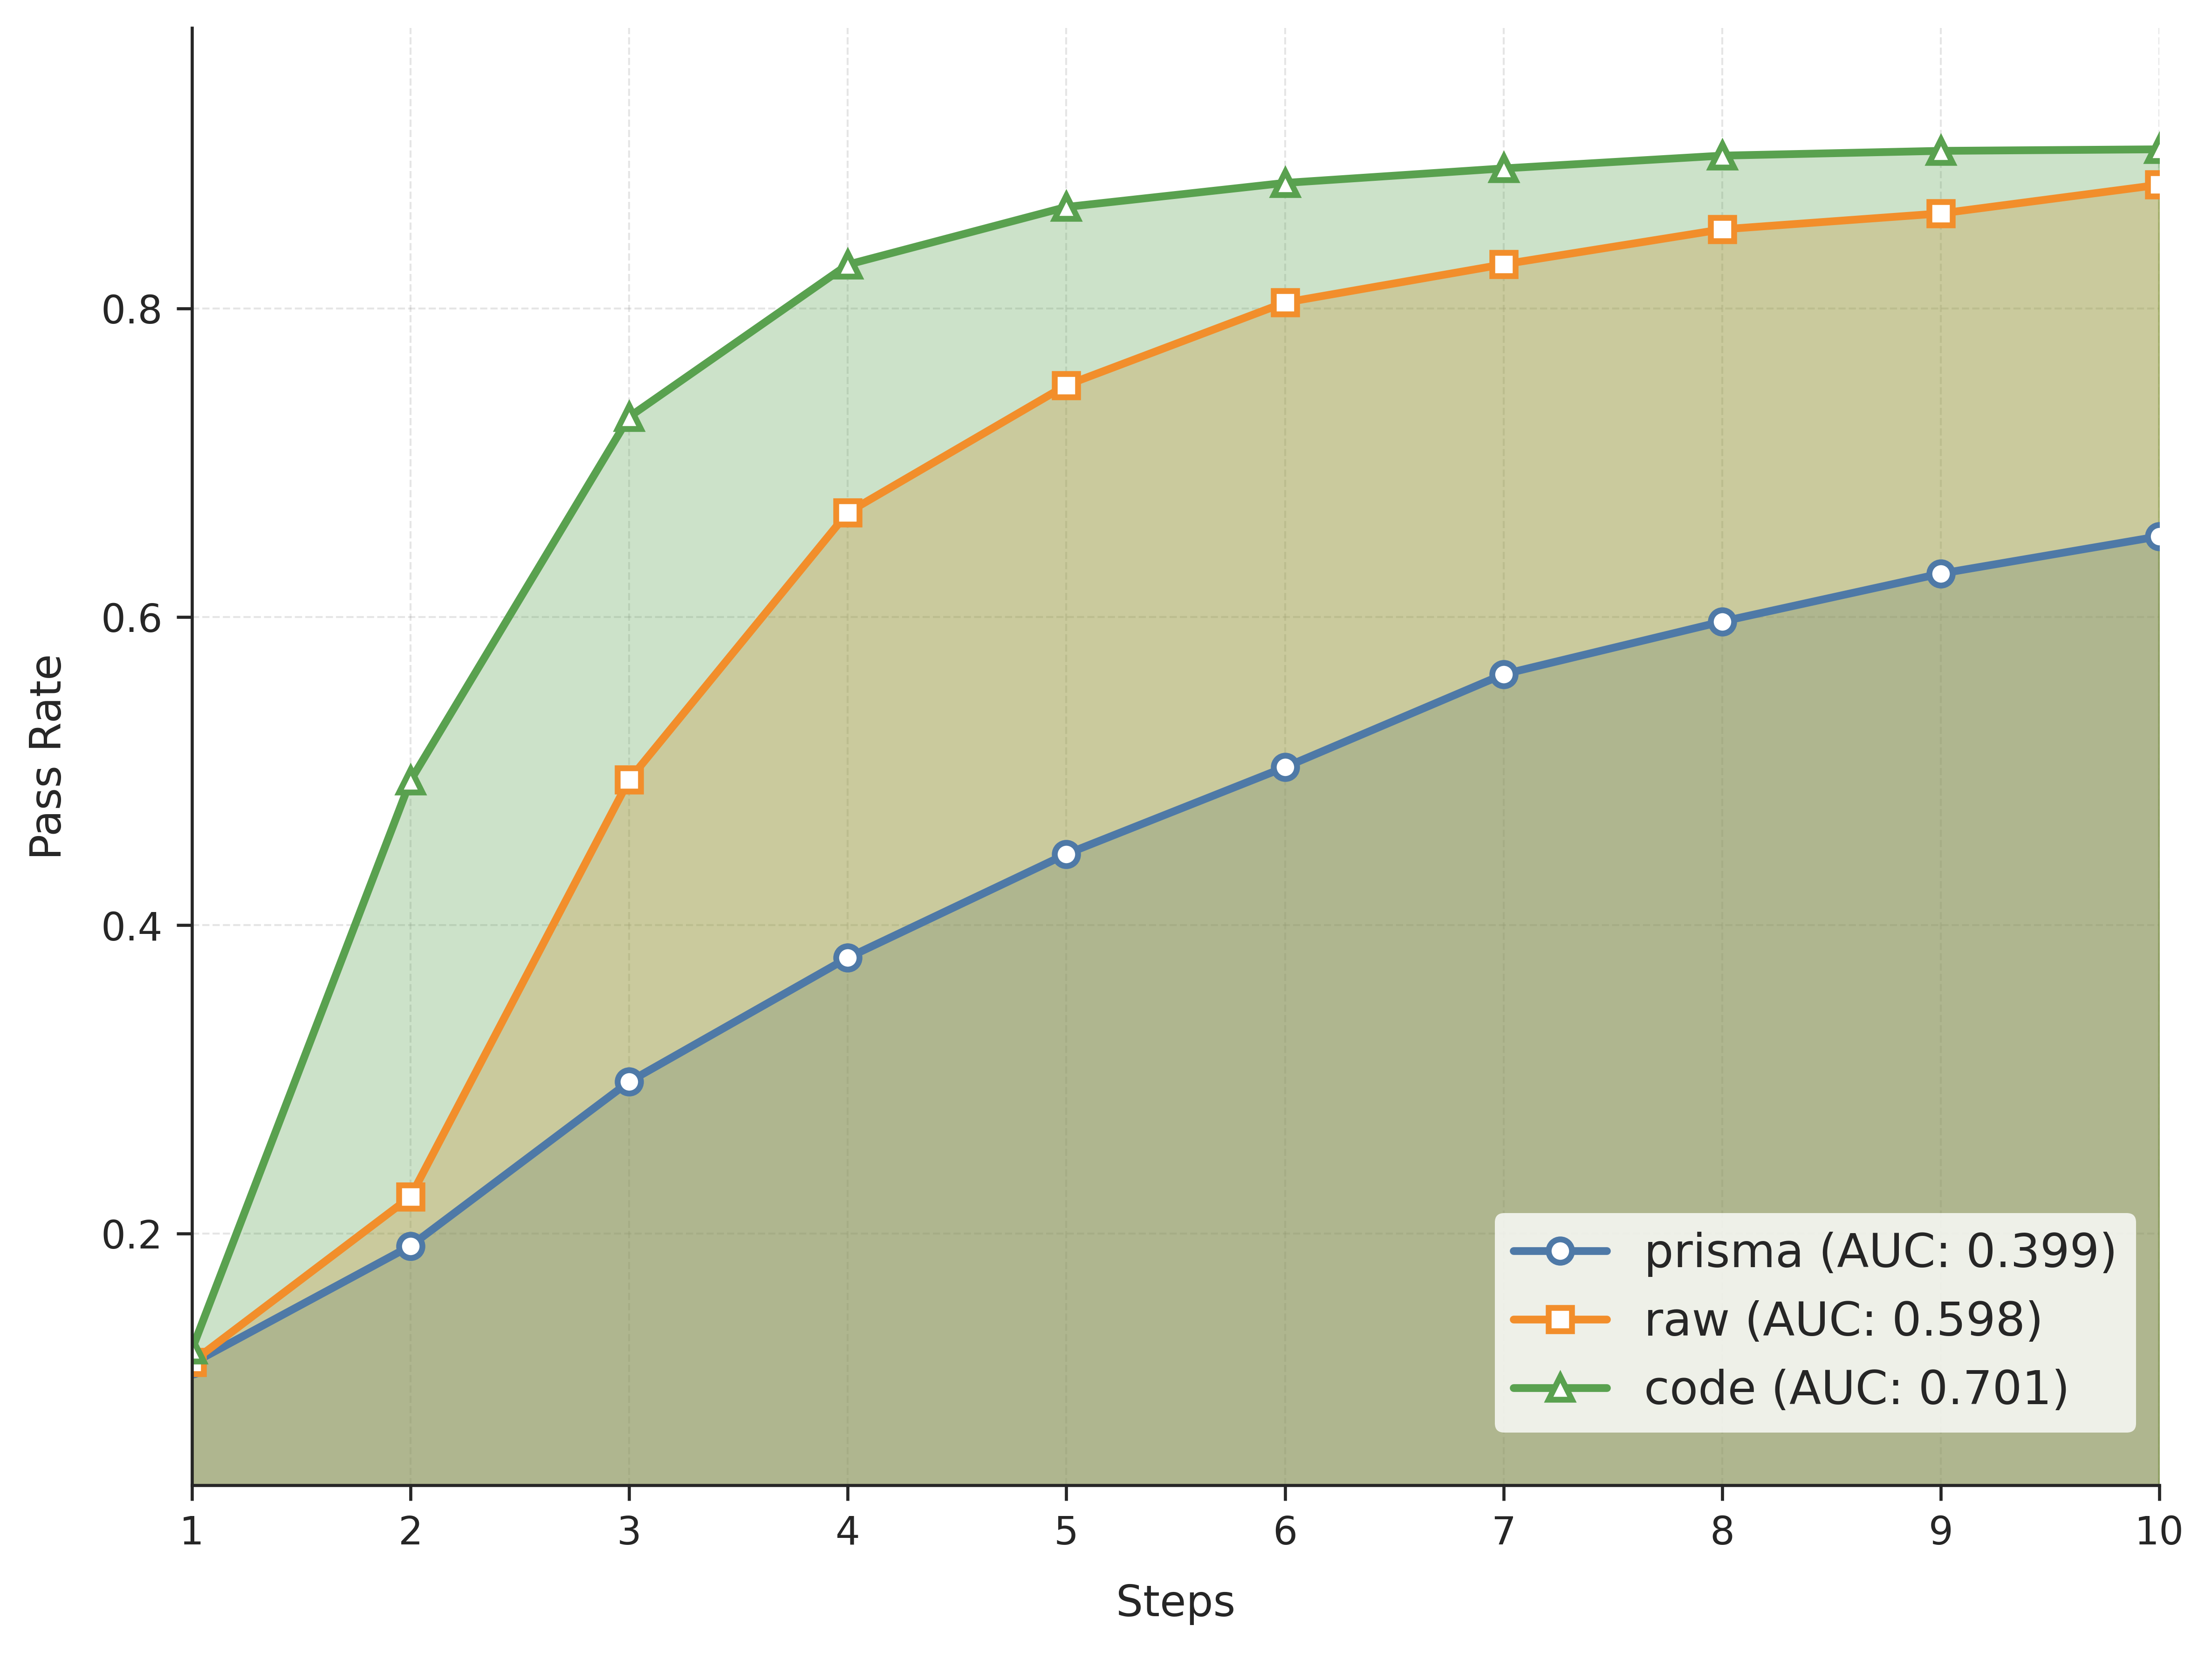

In [26]:
fig1, aucs = plot_rates_over_steps(y_lists, model_names, save_name="abl_prs")
for result, auc in zip(result_lists, aucs):
    result.update({"PRS_AUC": round(auc, 4)})

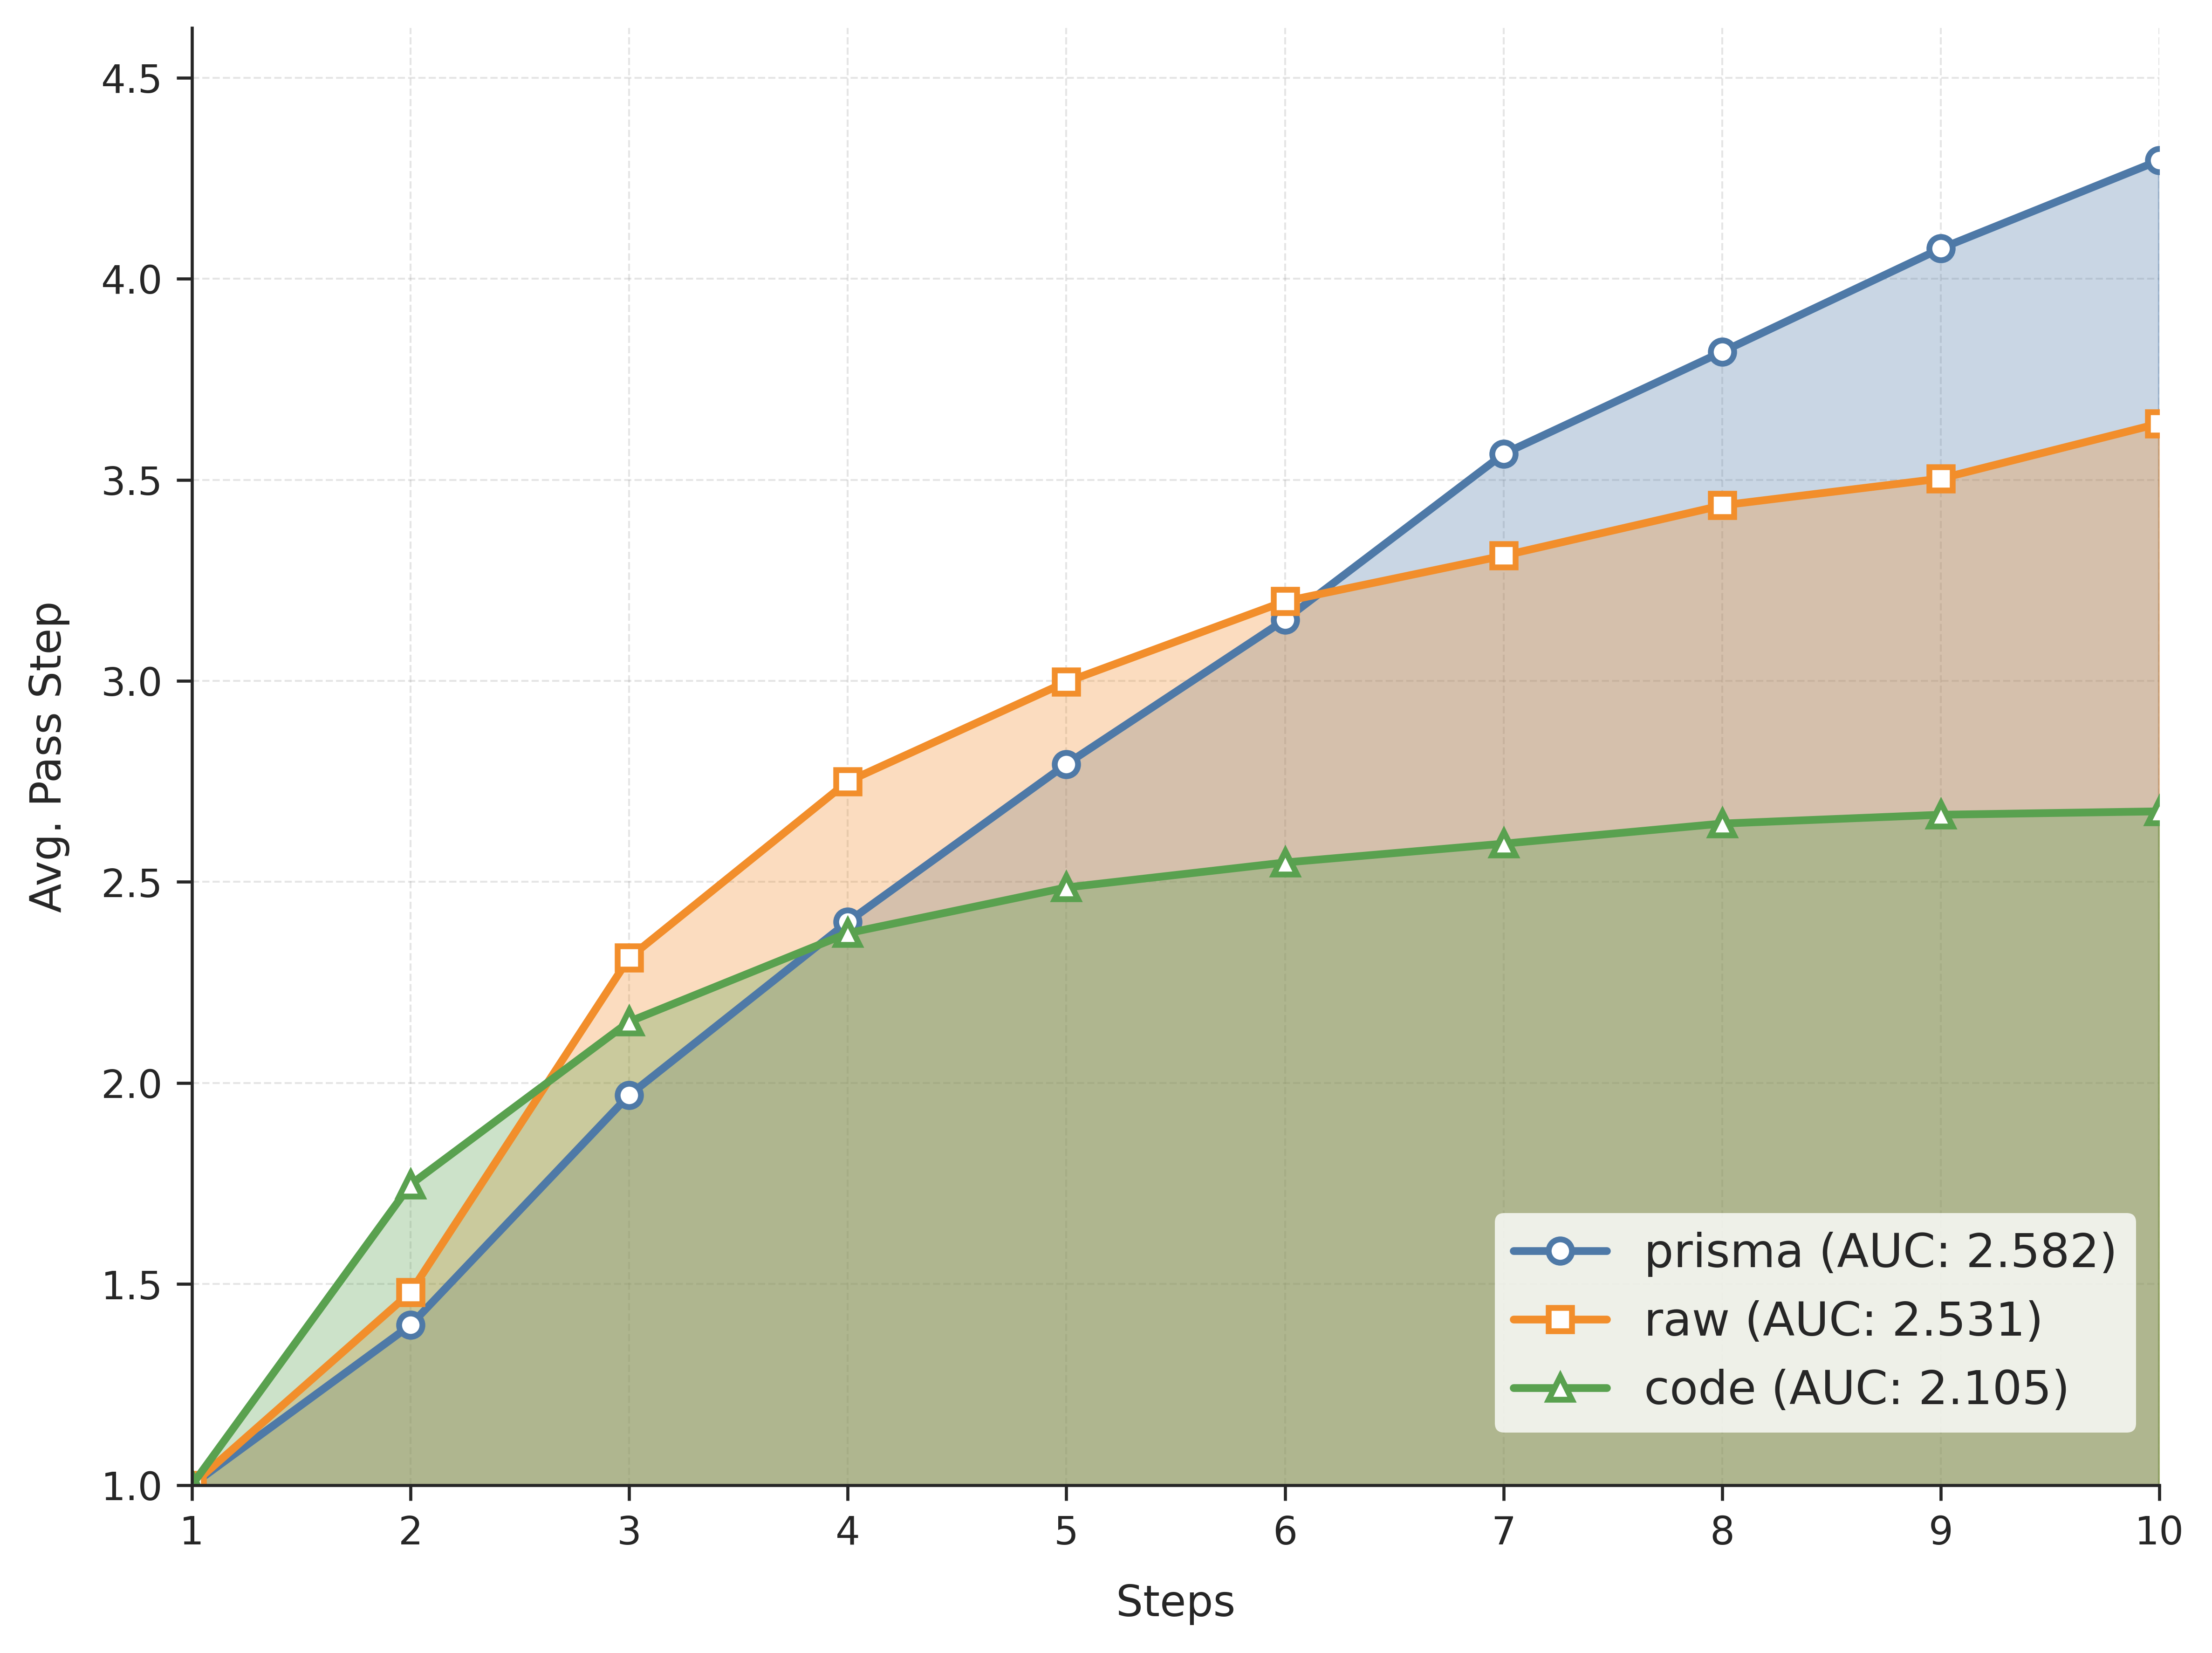

In [27]:
fig2, aucs = plot_rates_over_steps(avg_steps, model_names, title="Avg. Pass Steps over Steps", y_label="Avg. Pass Step", save_name="abl_apss")
for result, auc in zip(result_lists, aucs):
    result.update({"APSS_AUC": round(auc, 4)})

In [28]:
result_df = pd.DataFrame(result_lists)
result_df.to_csv("ablation.csv")